# Reservoir Simulation Experimental Design using Latin Hypercube Sampling (LHS)
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

## Objective
Generate a robust sensitivity analysis table for a reservoir simulation model. We will transform uncertainty ranges defined in `parameters.csv` into a discrete set of simulation jobs using `scipy.stats`.

### Workflow
1.  **Load Parameters:** Read the variable definitions (Porosity, Permeability, etc.).
2.  **LHS Generation:** Create normalized samples in the $0$ to $1$ range.
3.  **Inverse Transformation:** Map normalized samples to physical distributions (Normal, LogNormal, Uniform).
4.  **Correlation Check:** Visualize the samples to ensure the design space is covered uniformly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc # Quasi-Monte Carlo module for LHS
from scipy.stats import norm, lognorm, uniform, triang

# Configuration
SAMPLE_SIZE = 50  # Number of simulation runs to generate
SEED = 42         # Ensure reproducibility

print(f"Libraries loaded. Generating design for {SAMPLE_SIZE} runs.")

Libraries loaded. Generating design for 50 runs.


## Step 1: Load Parameter Definitions
We read the `parameters.csv` file which dictates the Min, Max, Mean, or StdDev for our reservoir properties.

In [2]:
# Load the input parameters
try:
    params_df = pd.read_csv('parameters.csv')
    print("Parameters loaded successfully:")
    display(params_df)
except FileNotFoundError:
    print("Error: 'parameters.csv' not found. Please ensure the file exists.")

Parameters loaded successfully:


,Parameter,Distribution,P1,P2
0,Porosity,normal,0.20,0.03
1,Permeability_mD,lognormal,50.00,0.80
2,Water_Saturation,uniform,0.15,0.35
3,Thickness_ft,triangular,50.00,150.00


## Step 2: Generate Unit Hypercube Samples
We use `scipy.stats.qmc.LatinHypercube` to generate samples.
The result is a matrix of shape `(n_samples, n_parameters)` where every value is between $0.0$ and $1.0$.

In [3]:
# Initialize the LHS generator
n_params = len(params_df)
sampler = qmc.LatinHypercube(d=n_params, seed=SEED)

# Generate samples (results are in [0, 1])
lhs_samples = sampler.random(n=SAMPLE_SIZE)

print(f"Generated LHS matrix shape: {lhs_samples.shape}")
print("First 5 rows (Normalized):")
print(lhs_samples[:5])

Generated LHS matrix shape: (50, 4)
First 5 rows (Normalized):
[[0.64452088 0.09122243 0.38282804 0.98605264]
 [0.27811645 0.94048755 0.50477721 0.72427871]
 [0.15743773 0.53099228 0.33258404 0.2414647 ]
 [0.8671227  0.92354477 0.61113172 0.45545523]
 [0.2889083  0.59872365 0.98344738 0.26736671]]


## Step 3: Inverse Transform Sampling (PPF)
This is the critical step. We map the LHS values (probabilities) to physical values using the **Percent Point Function (PPF)**.

**Handling different distributions:**
1.  **Normal:** Used for Porosity (P1=Mean, P2=StdDev).
2.  **LogNormal:** Used for Permeability (P1=Scale/Median, P2=Shape/Sigma).
3.  **Uniform:** Used for Saturation (P1=Min, P2=Width (Max-Min)).
4.  **Triangular:** Used for Thickness (P1=Min, P2=Max).

In [4]:
# Create a placeholder for physical values
physical_samples = np.zeros_like(lhs_samples)
param_names = params_df['Parameter'].tolist()

for i, row in params_df.iterrows():
    dist_type = row['Distribution'].lower()
    p1 = row['P1']
    p2 = row['P2']
    
    # Get the column of normalized samples for this parameter
    u_vec = lhs_samples[:, i]
    
    if dist_type == 'normal':
        # loc=mean, scale=std_dev
        physical_samples[:, i] = norm.ppf(u_vec, loc=p1, scale=p2)
        
    elif dist_type == 'lognormal':
        # s=shape (sigma), scale=median (exp(mu))
        # Note: Scipy lognorm parametrization requires care. 
        # Here we assume P1 is the median value (scale), P2 is the shape (sigma).
        physical_samples[:, i] = lognorm.ppf(u_vec, s=p2, scale=p1)
        
    elif dist_type == 'uniform':
        # loc=min, scale=range (max - min)
        width = p2 - p1
        physical_samples[:, i] = uniform.ppf(u_vec, loc=p1, scale=width)
        
    elif dist_type == 'triangular':
        # loc=min, scale=(max-min), c=(mode-min)/(max-min)
        # We assume mode is the midpoint for simplicity here
        mode = (p1 + p2) / 2
        width = p2 - p1
        c = (mode - p1) / width
        physical_samples[:, i] = triang.ppf(u_vec, c=c, loc=p1, scale=width)

# Convert to DataFrame
design_df = pd.DataFrame(physical_samples, columns=param_names)

# Rounding for clean output (optional)
design_df = design_df.round(4)

print("Transformed Physical Samples (First 5 runs):")
display(design_df.head())

Transformed Physical Samples (First 5 runs):


,Porosity,Permeability_mD,Water_Saturation,Thickness_ft
0,0.2111,17.2086,0.2266,141.6491
1,0.1823,174.0124,0.2510,112.8704
2,0.1698,53.2094,0.2165,84.7466
3,0.2334,156.8805,0.2722,97.7208
4,0.1833,61.0723,0.3467,86.5627


## Step 4: Quality Control & Visualization
We visualize the data to verify:
1.  **Marginal Distributions:** Does the histogram of Porosity look Normal? Does Permeability look LogNormal?
2.  **Space Filling:** Scatter plots should show samples spread out, not clustered (which happens in random Monte Carlo).

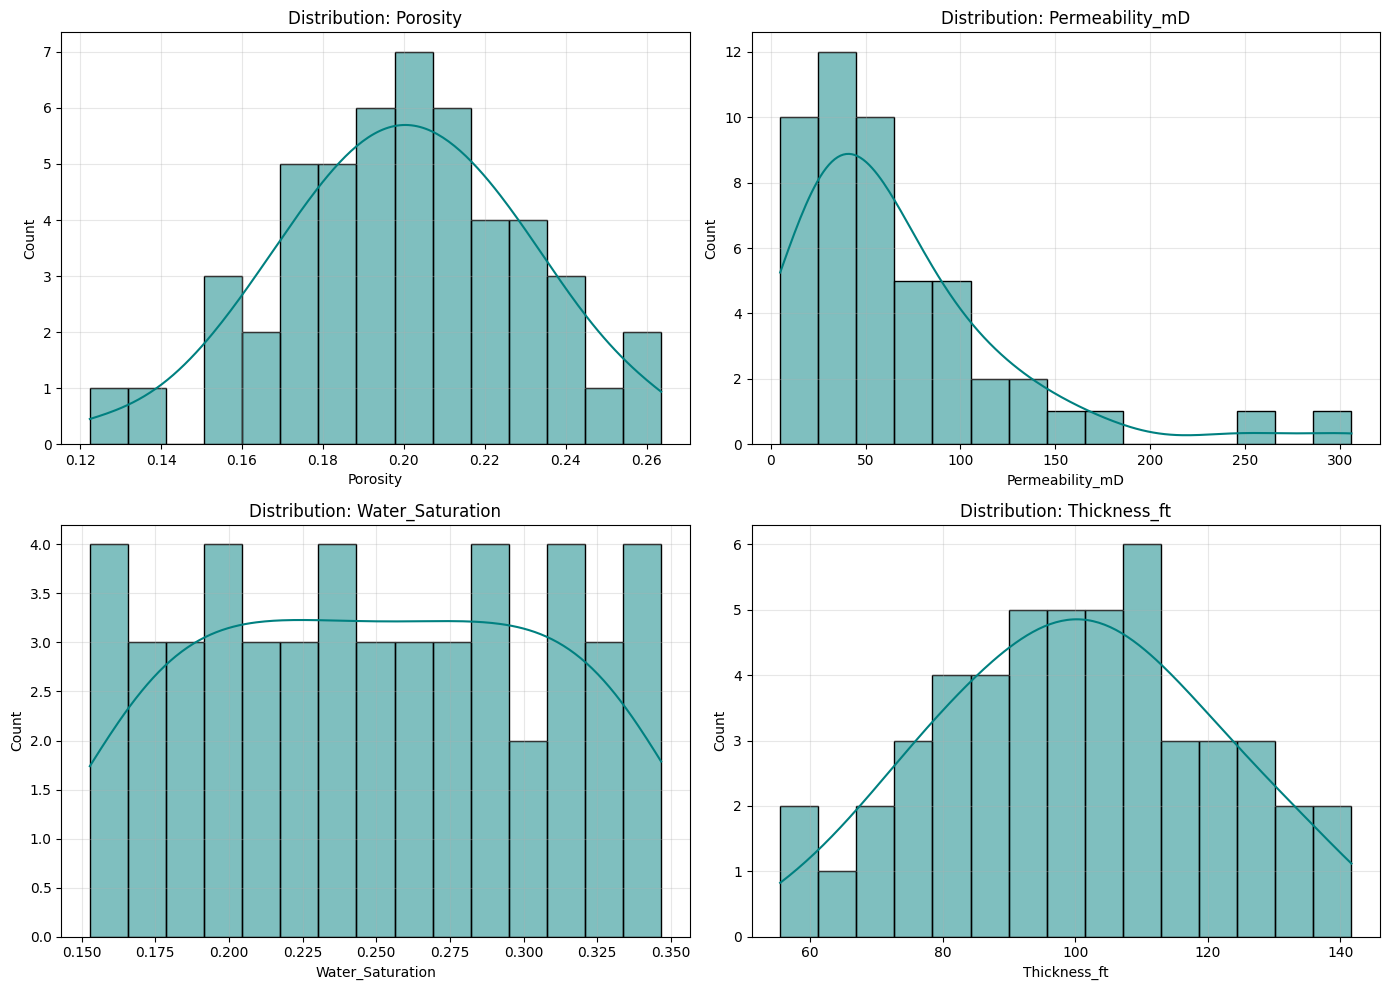

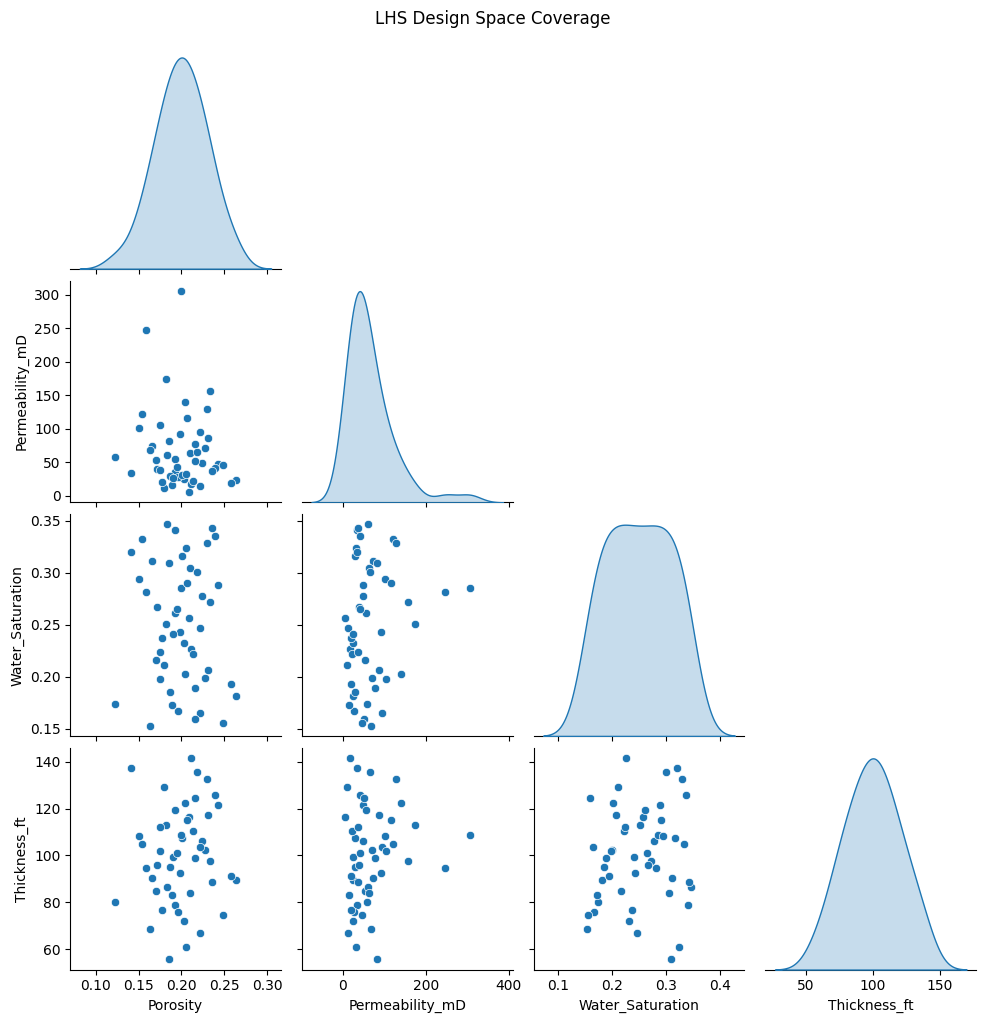

In [5]:
# Plotting distributions
plt.figure(figsize=(14, 10))

for idx, col in enumerate(design_df.columns):
    plt.subplot(2, 2, idx+1)
    sns.histplot(design_df[col], kde=True, bins=15, color='teal')
    plt.title(f'Distribution: {col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Pairplot to check for unintentional correlations (should be random scatter)
sns.pairplot(design_df, kind="scatter", diag_kind="kde", corner=True)
plt.suptitle("LHS Design Space Coverage", y=1.02)
plt.show()

## Step 5: Export Experiment Table
Save the table to CSV. This file is now ready to be fed into your reservoir simulation workflow script (e.g., Python script generating .DATA files).

In [6]:
output_filename = 'design_table.csv'
design_df.to_csv(output_filename, index_label='Run_ID')
print(f"Experimental design saved to {output_filename}")

Experimental design saved to design_table.csv
